In [ ]:
# %% [setup] Paths & imports
import os, sys, textwrap
import numpy as np
import pandas as pd
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Đường dẫn tới folder data
import os
DATA_DIR = "/content/drive/MyDrive/PTDLKD_Data"   # nhớ check tên chính xác
os.listdir(DATA_DIR)[:15]   # xem thử có file gì trong đó



# %% [setup] Robust CSV reader (thử nhiều encoding & delimiter)
def read_csv_smart(path, encodings=("utf-8","utf-8-sig","cp1258","latin1","ISO-8859-1")):
    last_err = None
    for enc in encodings:
        try:
            # pandas sẽ tự nhận dạng delimiter nếu sep=None + engine="python"
            return pd.read_csv(path, sep=None, engine="python", encoding=enc)
        except Exception as e:
            last_err = e
    raise last_err

# %% [setup] Profile helpers
def basic_info(df, name):
    print(f"\n=== {name}: shape={df.shape} ===")
    print("\n-- dtypes --")
    print(df.dtypes)
    print("\n-- head(5) --")
    print(df.head(5))

def describe_numeric(df, name):
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if not num_cols:
        print(f"\n[{name}] No numeric columns.")
        return
    print(f"\n=== Descriptive stats (numeric) for {name} ===")
    display(df[num_cols].describe().T[['mean','50%','std','min','max']].rename(columns={'50%':'median'}))

def freq_tables(df, name, top_k=15, min_card=2, max_card=200):
    cat_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()
    # cũng tính với numeric thấp cardinality (ví dụ 0/1, 1..5)
    for c in df.columns:
        if c not in cat_cols:
            nun = df[c].nunique(dropna=True)
            if 0 < nun <= max_card and nun >= min_card:
                cat_cols.append(c)
    if not cat_cols:
        print(f"\n[{name}] No categorical-like columns for frequency tables.")
        return
    print(f"\n=== Frequency tables for {name} ===")
    for col in cat_cols:
        vc = df[col].value_counts(dropna=False)
        if len(vc) == 0:
            continue
        print(f"\n-- {col} (unique={vc.size}) --")
        total = vc.sum()
        out = pd.DataFrame({
            'count': vc,
            'percent': (vc/total*100).round(2)
        })
        display(out.head(top_k))

def iqr_outliers_report(df, name, k=1.5):
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if not num_cols:
        print(f"\n[{name}] No numeric columns for outlier check.")
        return
    print(f"\n=== IQR outlier check for {name} (k={k}) ===")
    rows = []
    for col in num_cols:
        s = df[col].dropna()
        if s.empty:
            continue
        q1, q3 = np.percentile(s, [25, 75])
        iqr = q3 - q1
        lo, hi = q1 - k*iqr, q3 + k*iqr
        out_cnt = ((s < lo) | (s > hi)).sum()
        rows.append({
            'column': col, 'q1': q1, 'q3': q3, 'iqr': iqr,
            'lower': lo, 'upper': hi, 'outliers': int(out_cnt),
            'outlier_ratio_%': round(100 * out_cnt / max(len(s),1), 2)
        })
    rep = pd.DataFrame(rows).sort_values('outliers', ascending=False)
    display(rep)


Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# %% [load] Load core tables
paths = {
    "City": os.path.join(DATA_DIR, "City.csv"),
    "Respondent": os.path.join(DATA_DIR, "Respondent.csv"),
    "BrandHealth": os.path.join(DATA_DIR, "BrandHealth.csv"),
    "BrandImage": os.path.join(DATA_DIR, "BrandImage.csv"),
    "Segmentation2017": os.path.join(DATA_DIR, "Segmentation3685Case2017.csv"),
    "Segmentation_Lookup": os.path.join(DATA_DIR, "Segmentation_Lookup.csv"),
    "DayOfWeek": os.path.join(DATA_DIR, "DayOfWeek.csv"),
    "DayPart": os.path.join(DATA_DIR, "DayPart.csv"),
    "Companion": os.path.join(DATA_DIR, "Companion.csv"),
    "NeedstateDayPart": os.path.join(DATA_DIR, "NeedstateDayPart.csv"),
    "Competitor": os.path.join(DATA_DIR, "Competitor.csv"),
}

dfs = {}
for name, p in paths.items():
    df = read_csv_smart(p)
    dfs[name] = df
    basic_info(df, name)



=== City: shape=(6, 2) ===

-- dtypes --
﻿CityID      int64
CityName    object
dtype: object

-- head(5) --
   ﻿CityID     CityName
0        3      Cần Thơ
1        5      Đà Nẵng
2        1       Hà Nội
3        4    Hải Phòng
4        2  Hồ Chí Minh

=== Respondent: shape=(11737, 23) ===

-- dtypes --
RespondentKey                   int64
RespondentID                    int64
CityID                          int64
GroupSize                       int64
Age                             int64
Gender                         object
TopOfMind                      object
BrandUseMostOften              object
BrandUseMostOften_Previous     object
MostFavourite                  object
AgeGroup                       object
MPI                            object
Occupation                     object
OccupationGroup                object
Year                            int64
MPI_Mean_Use                  float64
Unnamed: 16                   float64
Unnamed: 17                   float64
Unnamed: 1

Data Understanding - Respondent

In [ ]:
# %% [understanding] Respondent
resp = dfs["Respondent"].copy()

# Descriptive stats (numeric)
describe_numeric(resp, "Respondent")

# Frequency tables (categorical & low-cardinality numeric)
freq_tables(resp, "Respondent", top_k=15)

# Outliers (IQR)
iqr_outliers_report(resp, "Respondent", k=1.5)



=== Descriptive stats (numeric) for Respondent ===


,mean,median,std,min,max
RespondentKey,5869.000000,5869.0,3388.324389,1.0,11737.0
RespondentID,442930.753174,433943.0,267371.436775,89100.0,863754.0
CityID,2.856607,2.0,1.620203,1.0,6.0
GroupSize,3.287893,3.0,1.331805,1.0,35.0
Age,35.222288,34.0,10.824721,16.0,60.0
Year,2017.986368,2018.0,0.783686,2017.0,2019.0
MPI_Mean_Use,7338.744389,6999.0,4668.481342,1499.0,112499.0
Unnamed: 16,NaN,NaN,NaN,NaN,NaN
Unnamed: 17,NaN,NaN,NaN,NaN,NaN
Unnamed: 18,NaN,NaN,NaN,NaN,NaN



=== Frequency tables for Respondent ===

-- Gender (unique=2) --


,count,percent
Gender,,
Female,6548,55.79
Male,5189,44.21



-- TopOfMind (unique=29) --


,count,percent
TopOfMind,,
Other,3799,32.37
Street Coffee,2336,19.90
Independent Cafe,1753,14.94
Highlands Coffee,1685,14.36
Trung Nguyên,598,5.09
Milano,385,3.28
C?ng Cà Phê,299,2.55
Aha Cafe,240,2.04
The Coffee House,229,1.95



-- BrandUseMostOften (unique=30) --


,count,percent
BrandUseMostOften,,
Other,3891,33.15
Street Coffee,2733,23.29
Independent Cafe,1853,15.79
Highlands Coffee,1486,12.66
Milano,389,3.31
C?ng Cà Phê,279,2.38
Trung Nguyên,259,2.21
Aha Cafe,245,2.09
The Coffee House,224,1.91



-- BrandUseMostOften_Previous (unique=30) --


,count,percent
BrandUseMostOften_Previous,,
NaN,5646,48.10
Don't have any brands,2642,22.51
Street Coffee,1584,13.50
Other,747,6.36
Independent Cafe,273,2.33
Milano,153,1.30
Trung Nguyên,134,1.14
Highlands Coffee,128,1.09
C?ng Cà Phê,117,1.00



-- MostFavourite (unique=31) --


,count,percent
MostFavourite,,
Other,3827,32.61
Highlands Coffee,1953,16.64
Street Coffee,1786,15.22
Independent Cafe,1696,14.45
Trung Nguyên,642,5.47
Milano,418,3.56
The Coffee House,311,2.65
C?ng Cà Phê,304,2.59
Aha Cafe,246,2.10



-- AgeGroup (unique=7) --


,count,percent
AgeGroup,,
45+,2578,21.96
25 - 29,1984,16.90
30 - 34,1959,16.69
35 - 39,1873,15.96
20 - 24,1408,12.00
40 - 44,1261,10.74
16 - 19,674,5.74



-- MPI (unique=6) --


,count,percent
MPI,,
VND 4.5m - VND 8.9m,4405,37.53
NaN,3717,31.67
Under VND 4.5m,1805,15.38
VND 9m - VND 14.9m,1387,11.82
VND 15m - VND 24.9m,378,3.22
VND 25m+,45,0.38



-- Occupation (unique=28) --


,count,percent
Occupation,,
Officer - Staff level,1993,16.98
Unskilled Labor (worker,1990,16.95
Housewife,1554,13.24
Pupil / Student,1235,10.52
Small Business (small shop owner,1138,9.70
Skilled Labor (tailor,1101,9.38
Broker/ Service provider with no employee,505,4.30
Semi-skilled labor (salesperson,475,4.05
Freelance,429,3.66



-- OccupationGroup (unique=7) --


,count,percent
OccupationGroup,,
Blue Collar,3566,30.38
None Working,2983,25.42
White Collar,2810,23.94
Self Employed - Small Business and Freelance,2072,17.65
Self Employed - Company Owner,155,1.32
Other Occupations,134,1.14
Refuse,17,0.14



-- CityID (unique=6) --


,count,percent
CityID,,
1,3034,25.85
2,3029,25.81
3,1622,13.82
5,1616,13.77
4,1563,13.32
6,873,7.44



-- GroupSize (unique=16) --


,count,percent
GroupSize,,
3,3455,29.44
4,3437,29.28
2,2679,22.83
5,1127,9.60
1,612,5.21
6,324,2.76
7,48,0.41
8,24,0.20
10,23,0.20



-- Age (unique=45) --


,count,percent
Age,,
28,456,3.89
29,449,3.83
27,417,3.55
34,416,3.54
33,415,3.54
30,401,3.42
35,388,3.31
37,375,3.20
39,375,3.20



-- Year (unique=3) --


,count,percent
Year,,
2018,4527,38.57
2017,3685,31.40
2019,3525,30.03



-- MPI_Mean_Use (unique=14) --


,count,percent
MPI_Mean_Use,,
NaN,3717,31.67
5499.0,1727,14.71
6999.0,1499,12.77
8249.0,1179,10.05
10499.0,982,8.37
1499.0,947,8.07
3749.0,858,7.31
13499.0,405,3.45
17499.0,280,2.39



=== IQR outlier check for Respondent (k=1.5) ===


,column,q1,q3,iqr,lower,upper,outliers,outlier_ratio_%
6,MPI_Mean_Use,5499.0,8249.0,2750.0,1374.0,12374.0,828,10.32
3,GroupSize,2.0,4.0,2.0,-1.0,7.0,55,0.47
0,RespondentKey,2935.0,8803.0,5868.0,-5867.0,17605.0,0,0.00
2,CityID,1.0,4.0,3.0,-3.5,8.5,0,0.00
1,RespondentID,138413.0,765470.0,627057.0,-802172.5,1706055.5,0,0.00
4,Age,27.0,43.0,16.0,3.0,67.0,0,0.00
5,Year,2017.0,2019.0,2.0,2014.0,2022.0,0,0.00


Data Understanding — BrandHealth

In [ ]:
# %% [understanding] BrandHealth
bh = dfs["BrandHealth"].copy()

# Descriptive stats
describe_numeric(bh, "BrandHealth")

# Frequency tables (nhất là Is_Aware, Is_Trial, Used_P3M, Used_P1M, NPS_Group, Brand)
freq_tables(bh, "BrandHealth", top_k=15)

# Outliers
iqr_outliers_report(bh, "BrandHealth", k=1.5)



=== Descriptive stats (numeric) for BrandHealth ===


,mean,median,std,min,max
BrandHealthKey,37210.000000,37210.0,21483.059178,1.0,74419.0
RespondentID,478277.867856,443720.0,268141.831294,89100.0,863754.0
Year,2018.091160,2018.0,0.781323,2017.0,2019.0
CityID,2.626050,2.0,1.598127,1.0,6.0
Is_Spontaneous_Aware,0.416466,0.0,0.492976,0.0,1.0
Is_Aware,0.998468,1.0,0.039109,0.0,1.0
Is_Trial,0.635993,1.0,0.481154,0.0,1.0
Has_Brand_Likability,0.138822,0.0,0.345763,0.0,1.0
Used_P3M,0.387656,0.0,0.487219,0.0,1.0
Used_P1M,0.260673,0.0,0.439005,0.0,1.0



=== Frequency tables for BrandHealth ===

-- Brand (unique=32) --


,count,percent
Brand,,
Street Coffee,10669,14.34
Trung Nguyên,9954,13.38
Other,9733,13.08
Highlands Coffee,8520,11.45
Milano,4699,6.31
C?ng Cà Phê,3929,5.28
The Coffee House,3830,5.15
Starbucks,3350,4.50
Phúc Long,2786,3.74



-- Segmentation (unique=5) --


,count,percent
Segmentation,,
NaN,60347,81.09
Seg.04,7503,10.08
Seg.02,2941,3.95
Seg.03,2702,3.63
Seg.01,926,1.24



-- Comprehension (unique=6) --


,count,percent
Comprehension,,
Did not answer,48073,64.60
Know a little,10517,14.13
Know it well,7096,9.54
Maybe do not know it,4698,6.31
Know it very well,3908,5.25
Do not know it at all,127,0.17



-- NPS_Group (unique=4) --


,count,percent
NPS_Group,,
NaN,52814,70.97
Passive,11221,15.08
Promoter,7804,10.49
Detractor,2580,3.47



-- dwh_create_date (unique=1) --


,count,percent
dwh_create_date,,
9/20/2025 14:42,74419,100.0



-- Year (unique=3) --


,count,percent
Year,,
2018,28371,38.12
2019,26416,35.50
2017,19632,26.38



-- CityID (unique=6) --


,count,percent
CityID,,
2,23121,31.07
1,22617,30.39
5,9366,12.59
4,7982,10.73
3,6729,9.04
6,4604,6.19



-- Is_Spontaneous_Aware (unique=2) --


,count,percent
Is_Spontaneous_Aware,,
0,43426,58.35
1,30993,41.65



-- Is_Aware (unique=2) --


,count,percent
Is_Aware,,
1,74305,99.85
0,114,0.15



-- Is_Trial (unique=2) --


,count,percent
Is_Trial,,
1,47330,63.6
0,27089,36.4



-- Has_Brand_Likability (unique=2) --


,count,percent
Has_Brand_Likability,,
0,64088,86.12
1,10331,13.88



-- Used_P3M (unique=2) --


,count,percent
Used_P3M,,
0,45570,61.23
1,28849,38.77



-- Used_P1M (unique=2) --


,count,percent
Used_P1M,,
0,55020,73.93
1,19399,26.07



-- Frequency_Visits (unique=61) --


,count,percent
Frequency_Visits,,
NaN,28063,37.71
0.0,27089,36.40
2.0,3413,4.59
4.0,2810,3.78
1.0,2651,3.56
3.0,2354,3.16
5.0,1444,1.94
10.0,1145,1.54
8.0,970,1.30



-- PPA (unique=82) --


,count,percent
PPA,,
NaN,60346,81.09
30000.0,1604,2.16
20000.0,1397,1.88
15000.0,1346,1.81
50000.0,1345,1.81
10000.0,1236,1.66
25000.0,975,1.31
40000.0,944,1.27
12000.0,783,1.05



-- NPS_Score (unique=12) --


,count,percent
NPS_Score,,
NaN,52814,70.97
8.0,7263,9.76
9.0,5470,7.35
7.0,3958,5.32
10.0,2334,3.14
6.0,1397,1.88
5.0,875,1.18
4.0,169,0.23
3.0,65,0.09



=== IQR outlier check for BrandHealth (k=1.5) ===


,column,q1,q3,iqr,lower,upper,outliers,outlier_ratio_%
7,Has_Brand_Likability,0.0,0.0,0.0,0.0,0.0,10331,13.88
10,Frequency_Visits,0.0,3.0,3.0,-4.5,7.5,5411,11.67
12,Spending,50000.0,200000.0,150000.0,-175000.0,425000.0,825,5.86
11,PPA,15000.0,40000.0,25000.0,-22500.0,77500.0,274,1.95
13,NPS_Score,7.0,9.0,2.0,4.0,12.0,139,0.64
5,Is_Aware,1.0,1.0,0.0,1.0,1.0,114,0.15
4,Is_Spontaneous_Aware,0.0,1.0,1.0,-1.5,2.5,0,0.00
3,CityID,1.0,4.0,3.0,-3.5,8.5,0,0.00
2,Year,2017.0,2019.0,2.0,2014.0,2022.0,0,0.00
1,RespondentID,140354.0,791013.0,650659.0,-835634.5,1767001.5,0,0.00


Data Understanding — Segmentation

In [ ]:
# %% [understanding] Segmentation
seg = dfs["Segmentation2017"].copy()
seg_lookup = dfs["Segmentation_Lookup"].copy() if "Segmentation_Lookup" in dfs else None

# Descriptive stats (Visit, Spending, PPA)
describe_numeric(seg, "Segmentation2017")

# Frequency (SegmentCode, CustomerType, BrandType, SpendingRange)
freq_tables(seg, "Segmentation2017", top_k=15)

# Outliers
iqr_outliers_report(seg, "Segmentation2017", k=1.5)

# (Optional) Join thử với lookup để xem mapping range numeric nếu cần
if seg_lookup is not None and {'SegmentCode','SegmentName'}.issubset(set(seg_lookup.columns)):
    seg_merged = seg.merge(seg_lookup, on='SegmentCode', how='left')
    print("\nSegmentation merged with lookup (head):")
    display(seg_merged.head(5))



=== Descriptive stats (numeric) for Segmentation2017 ===


,mean,median,std,min,max
2017SegmentationCaseKey,2472.500000,2472.5,1427.354196,1.0,4944.0
RespondentID,124746.726739,127602.5,14200.003243,89100.0,142479.0
Visit,9.286003,4.0,11.251593,1.0,120.0
Spending,185212.783172,120000.0,208383.542098,6000.0,2500000.0
PPA,26125.606796,20000.0,17454.005904,5000.0,100000.0



=== Frequency tables for Segmentation2017 ===

-- SegmentCode (unique=4) --


,count,percent
SegmentCode,,
Seg.01,2577,52.12
Seg.02,2104,42.56
Seg.03,218,4.41
Seg.04,45,0.91



-- CustomerType (unique=4) --


,count,percent
CustomerType,,
Mass,2577,52.12
Mass Asp,2104,42.56
Premium,218,4.41
Super Premium,45,0.91



-- SpendingRange (unique=4) --


,count,percent
SpendingRange,,
0 - 25000,2577,52.12
25000 - 59000,2104,42.56
60000 - 99000,218,4.41
100000+,45,0.91



-- BrandType (unique=3) --


,count,percent
BrandType,,
Independent,2194,44.38
Street,1525,30.85
Chain,1225,24.78



-- dwh_create_date (unique=1) --


,count,percent
dwh_create_date,,
2025-09-20 14:28:49.383000000,4944,100.0



-- Visit (unique=49) --


,count,percent
Visit,,
4,863,17.46
2,816,16.50
3,516,10.44
1,354,7.16
10,351,7.10
30,346,7.00
8,324,6.55
5,271,5.48
20,206,4.17



-- PPA (unique=56) --


,count,percent
PPA,,
30000,597,12.08
10000,590,11.93
15000,497,10.05
20000,475,9.61
25000,379,7.67
50000,377,7.63
12000,356,7.20
40000,320,6.47
8000,214,4.33



=== IQR outlier check for Segmentation2017 (k=1.5) ===


,column,q1,q3,iqr,lower,upper,outliers,outlier_ratio_%
2,Visit,3.00,10.00,7.00,-7.500,20.500,645,13.05
3,Spending,60000.00,240000.00,180000.00,-210000.000,510000.000,289,5.85
4,PPA,12000.00,35000.00,23000.00,-22500.000,69500.000,136,2.75
0,2017SegmentationCaseKey,1236.75,3708.25,2471.50,-2470.500,7415.500,0,0.00
1,RespondentID,113279.50,136523.25,23243.75,78413.875,171388.875,0,0.00



Segmentation merged with lookup (head):


,2017SegmentationCaseKey,RespondentID,SegmentCode,CustomerType,SpendingRange_x,Visit,Spending,BrandType,PPA,dwh_create_date,SegmentName,SpendingRange_y,MinSpending,MaxSpending
0,1,89100,Seg.04,Super Premium,100000+,4,400000,Independent,100000,2025-09-20 14:28:49.383000000,Super Premium,VND 100K+,100000,NaN
1,2,89100,Seg.03,Premium,60000 - 99000,2,120000,Chain,60000,2025-09-20 14:28:49.383000000,Premium,VND 60K - VND 99K,60000,99000.0
2,3,89100,Seg.01,Mass,0 - 25000,6,90000,Street,15000,2025-09-20 14:28:49.383000000,Mass,<VND 25K,0,24999.0
3,4,89101,Seg.01,Mass,0 - 25000,1,10000,Street,10000,2025-09-20 14:28:49.383000000,Mass,<VND 25K,0,24999.0
4,5,89101,Seg.02,Mass Asp,25000 - 59000,2,60000,Chain,30000,2025-09-20 14:28:49.383000000,Mass Asp,VND 25K - VND 59K,25000,59000.0


Vẽ outliers

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

DATA_DIR = "/content/drive/MyDrive/PTDLKD_Data"

def read_csv_smart(path):
    try:
        return pd.read_csv(path)
    except UnicodeDecodeError:
        return pd.read_csv(path, encoding="ISO-8859-1")

def plot_boxgrid(df, cols, title="", log_cols=None, ncols=3, figsize=(12, 4)):
    """
    Vẽ 1 hình gồm nhiều boxplot (mỗi cột 1 subplot) để nhìn outliers gọn.
    - cols: list tên cột numeric
    - log_cols: list cột cần log10 để giảm lệch
    """
    cols = [c for c in cols if c in df.columns]
    if not cols:
        print("No valid columns to plot.")
        return

    if log_cols is None: log_cols = []
    log_cols = [c for c in log_cols if c in cols]

    n = len(cols)
    ncols = min(ncols, n)
    nrows = int(np.ceil(n / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(figsize[0], figsize[1]*nrows))
    if nrows * ncols == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    for i, c in enumerate(cols):
        s = pd.to_numeric(df[c], errors="coerce").dropna()
        if len(s) == 0:
            axes[i].set_title(f"{c} (no data)")
            axes[i].axis("off")
            continue

        if c in log_cols:
            s = s[s > 0]
            s = np.log10(s)
            axes[i].boxplot(s.dropna(), vert=False)
            axes[i].set_xlabel("log10 scale")
        else:
            axes[i].boxplot(s, vert=False)
            axes[i].set_xlabel(c)

        axes[i].set_title(c)

    # ẩn axes thừa
    for j in range(i+1, len(axes)):
        axes[j].axis("off")

    if title:
        fig.suptitle(title, y=1.02, fontsize=12)
    fig.tight_layout()
    plt.show()


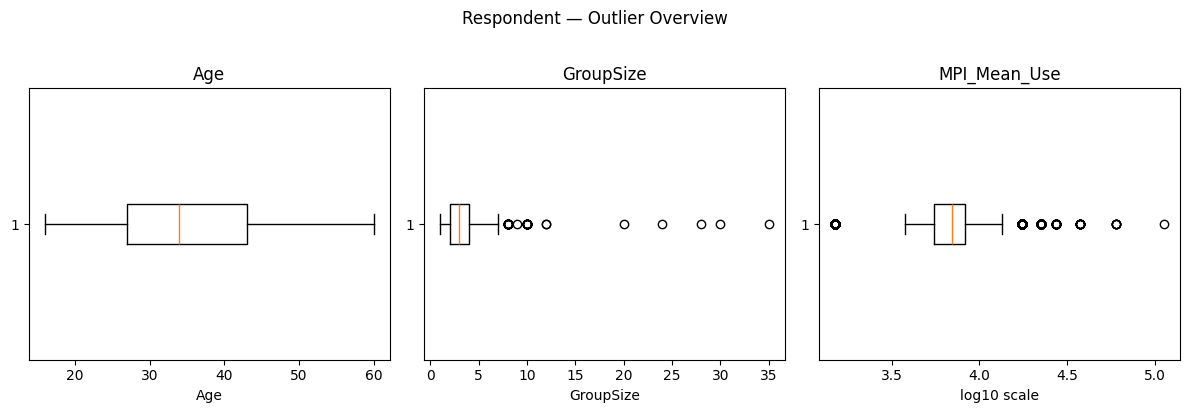

In [ ]:
resp = read_csv_smart(os.path.join(DATA_DIR, "Respondent.csv"))

plot_boxgrid(
    resp,
    cols=["Age", "GroupSize", "MPI_Mean_Use"],
    title="Respondent — Outlier Overview",
    log_cols=["MPI_Mean_Use"],   # thu nhập lệch -> log cho dễ nhìn
    ncols=3, figsize=(12,4)
)


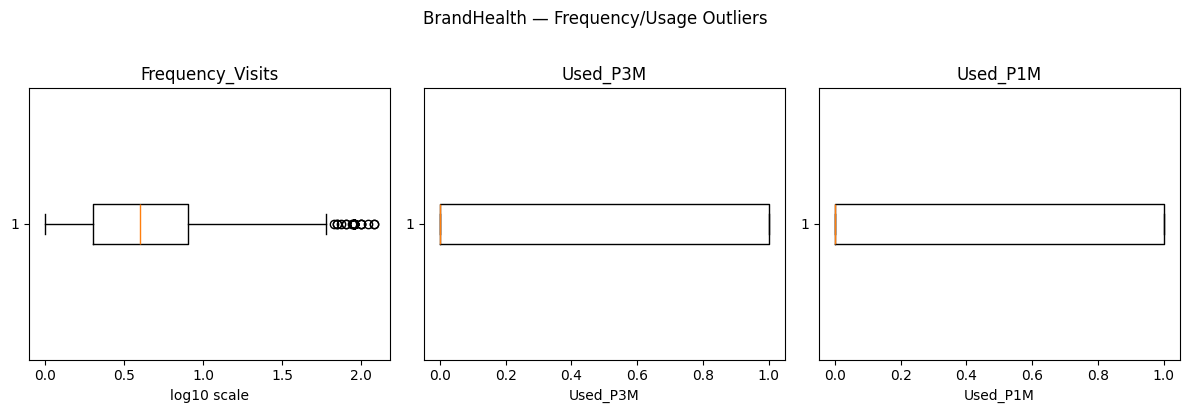

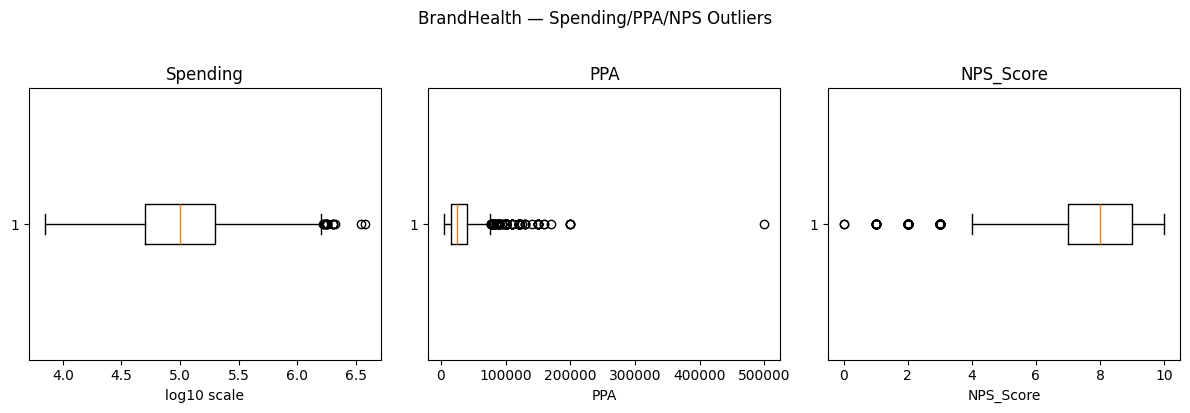

In [ ]:
bh = read_csv_smart(os.path.join(DATA_DIR, "BrandHealth.csv"))

# Hình 1: Frequency metrics
plot_boxgrid(
    bh,
    cols=["Frequency_Visits", "Used_P3M", "Used_P1M"],
    title="BrandHealth — Frequency/Usage Outliers",
    log_cols=["Frequency_Visits"],
    ncols=3, figsize=(12,4)
)

# Hình 2: Monetary + Satisfaction
plot_boxgrid(
    bh,
    cols=["Spending", "PPA", "NPS_Score"],
    title="BrandHealth — Spending/PPA/NPS Outliers",
    log_cols=["Spending"],   # Spending lệch mạnh
    ncols=3, figsize=(12,4)
)


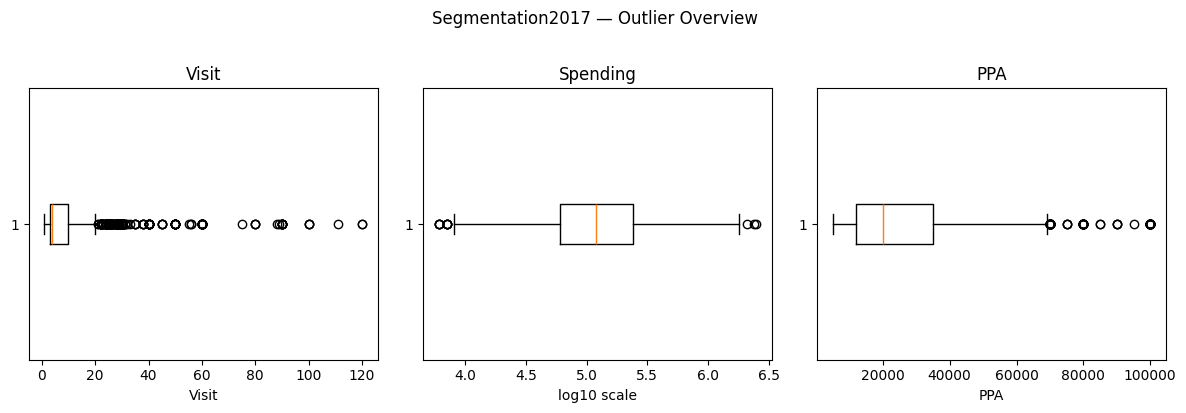

In [ ]:
seg = read_csv_smart(os.path.join(DATA_DIR, "Segmentation3685Case2017.csv"))

plot_boxgrid(
    seg,
    cols=["Visit", "Spending", "PPA"],
    title="Segmentation2017 — Outlier Overview",
    log_cols=["Spending"],   # Spending lệch mạnh
    ncols=3, figsize=(12,4)
)


BrandImage & hành vi

In [ ]:
# %% [understanding] BrandImage (sample)
bi = dfs["BrandImage"].copy()
print("BrandImage size:", bi.shape)
bi_sample = bi.sample(min(10000, len(bi)), random_state=42) if len(bi) > 10000 else bi

# Descriptive (nếu có numeric)
describe_numeric(bi_sample, "BrandImage (sample)")

# Frequency tables cho Attribute & Awareness (top 20)
freq_tables(bi_sample, "BrandImage (sample)", top_k=20)


BrandImage size: (643072, 8)

=== Descriptive stats (numeric) for BrandImage (sample) ===


,mean,median,std,min,max
﻿BrandImageKey,323062.0871,322691.0,185422.702334,117.0,643011.0
RespondentID,489972.8961,445046.5,271565.772477,89101.0,862458.0
Year,2018.1228,2018.0,0.788532,2017.0,2019.0
CityID,2.4793,2.0,1.541690,1.0,6.0



=== Frequency tables for BrandImage (sample) ===

-- Attribute (unique=28) --


,count,percent
Attribute,,
Clean,682,6.82
Nice environment design,527,5.27
Friendly staff,516,5.16
Popular brand,505,5.05
Good place for relaxing,502,5.02
Quick speed of service,479,4.79
Good value for money,465,4.65
Trusted brand,461,4.61
Good coffee taste,457,4.57



-- Awareness (unique=38) --


,count,percent
Awareness,,
Highlands Coffee,1637,16.37
Trung Nguyên,1193,11.93
Other,785,7.85
Other 1,655,6.55
Street / Half street coffee (including carts),623,6.23
Cộng Cà Phê,561,5.61
The Coffee House,540,5.40
Indepedent Cafe,485,4.85
Milano,446,4.46



-- dwh_create_date (unique=31) --


,count,percent
dwh_create_date,,
02:32.7,9626,96.26
Highlands Coffee,65,0.65
Other,36,0.36
Other 1,36,0.36
Trung Nguyên,27,0.27
Street / Half street coffee (including carts),27,0.27
The Coffee House,24,0.24
Indepedent Cafe,23,0.23
Cộng Cà Phê,18,0.18



-- Unnamed: 7 (unique=2) --


,count,percent
Unnamed: 7,,
NaN,9626,96.26
02:32.7,374,3.74



-- Year (unique=3) --


,count,percent
Year,,
2019,3798,37.98
2018,3632,36.32
2017,2570,25.70



-- CityID (unique=6) --


,count,percent
CityID,,
1,3403,34.03
2,3030,30.30
5,1052,10.52
3,1024,10.24
4,974,9.74
6,517,5.17


Code bổ sung

In [ ]:
import pandas as pd
import os

# Path tới folder trên Google Drive
folder_path = "/content/drive/MyDrive/PTDLKD_Data"

# Các file phụ cần bổ sung descriptive statistics
other_files = [
    "BrandImage.csv",
    "Companion.csv",
    "DayOfWeek.csv",
    "DayPart.csv",
    "NeedstateDayPart.csv"
]

def describe_only(file_path, file_name):
    print(f"\n=== Descriptive Statistics for {file_name} ===")
    try:
        df = pd.read_csv(file_path)
        numeric_desc = df.describe().T
        print(numeric_desc[["mean","50%","std","min","max"]])
    except Exception as e:
        print(f"⚠️ Error reading {file_name}: {e}")

# Chạy cho từng file chưa làm
for f in other_files:
    describe_only(os.path.join(folder_path, f), f)



=== Descriptive Statistics for BrandImage.csv ===
                        mean       50%            std      min       max
BrandImageKey  321536.500000  321536.5  185639.040491      1.0  643072.0
RespondentID   486938.048413  444693.0  272601.961288  89100.0  863754.0
Year             2018.112589    2018.0       0.792818   2017.0    2019.0
CityID              2.467719       2.0       1.540594      1.0       6.0

=== Descriptive Statistics for Companion.csv ===
                      mean       50%            std      min       max
CompanionKey   10370.00000   10370.0    5986.977952      1.0   20739.0
RespondentID  465470.81354  439750.0  272266.066681  89100.0  863754.0

=== Descriptive Statistics for DayOfWeek.csv ===
                       mean       50%            std      min       max
DayOfWeekKey   15768.500000   15768.5    9103.803381      1.0   31536.0
RespondentID  446773.148719  425233.0  269119.945399  89100.0  863754.0
CityID             3.567637       3.0       1.412371   